In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

2025-09-28 16:01:16.877780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759075277.183487      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759075277.270901      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


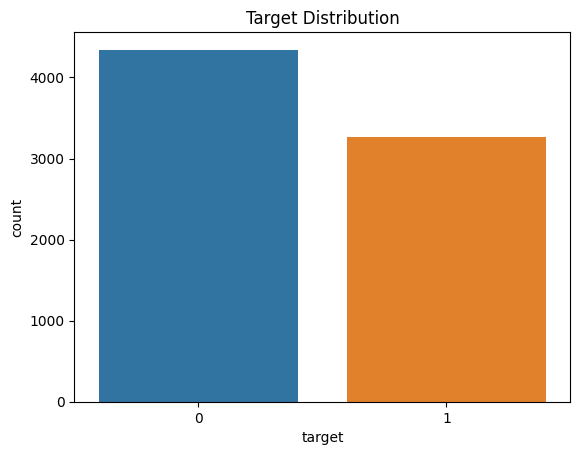

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


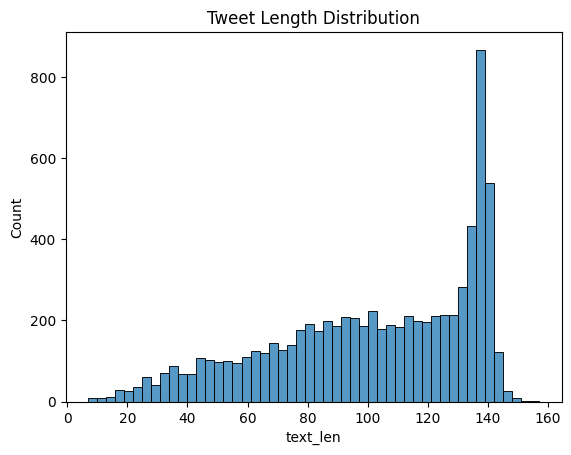

In [4]:
sns.countplot(x='target', data=train_df)
plt.title('Target Distribution')
plt.show()

train_df['text_len'] = train_df['text'].apply(len)
sns.histplot(train_df['text_len'], bins=50)
plt.title('Tweet Length Distribution')
plt.show()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [6]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

X = tokenizer.texts_to_sequences(train_df['clean_text'])
X = pad_sequences(X, maxlen=100)

y = train_df['target'].values

X_test = tokenizer.texts_to_sequences(test_df['clean_text'])
X_test = pad_sequences(X_test, maxlen=100)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-28 16:01:34.664432: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.5942 - loss: 0.6558 - val_accuracy: 0.7715 - val_loss: 0.4770
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8327 - loss: 0.3851 - val_accuracy: 0.7892 - val_loss: 0.4624
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9059 - loss: 0.2503 - val_accuracy: 0.7761 - val_loss: 0.5006
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9354 - loss: 0.1752 - val_accuracy: 0.7853 - val_loss: 0.5860
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9514 - loss: 0.1394 - val_accuracy: 0.7682 - val_loss: 0.7368


In [10]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       869
           1       0.76      0.74      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

F1 Score: 0.7498051441932969


In [11]:
final_preds = (model.predict(X_test) > 0.5).astype("int32")
sample_submission['target'] = final_preds
sample_submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
